# Benchmark optimizers 

In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
plt.rcParams.update({'font.size': 18})

In [3]:
def plot_results(inputs,obj):
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('X')
    ax.set_xlabel('function evaluation')
    ax.plot(inputs)
    ax2.set_ylabel('f(X)')
    ax2.set_xlabel('function evaluation'); ax2.set_yscale('log')
    ax2.plot(obj,'--b');  

# Booth function

In [40]:
class function:
    def __init__(self):
        self.my_counter= 0
        self.my_x = []
        self.my_y = []
    
    def Booth(self,x):
        y = (x[0]+2*x[1]-7)**2 + (x[1]+2*x[0]-5)**2
        self.my_counter += 1
        self.my_x += [x]  
        self.my_y += [y]
        return y

x0 = np.array([1,3]).astype('float64') #this is the maximum location
xs = np.array([0.5,0.5]) #start point

f = function()

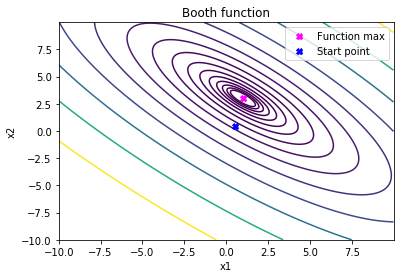

In [41]:
x = np.arange(-10, 10, 0.01) 
y = np.arange(-10, 10, 0.01)
X, Y = np.meshgrid(x, y)

Z = f.Booth([X,Y])
plt.contour(X, Y, Z, levels = np.logspace(0, 10, 15, base = 2));
plt.title('Booth function')
plt.plot(x0[0],x0[1],'X',color='magenta',label='Function max')
plt.plot(xs[0],xs[1],'Xb', label = 'Start point'); 
plt.legend(); plt.xlabel('x1'); plt.ylabel('x2')
plt.show()

# SLAC GP

In [6]:
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import importlib

In [7]:
mi_module = importlib.import_module('machine_interfaces.function_mi')

acquisition_delay = 0
ndim = 2
dev_ids =  [str(x+1) for x in np.arange(ndim)] 
start_point = np.zeros(ndim)+xs  

mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point,funcobj=['booth'][0]) 

In [8]:
# Create the gp
gp_ls = np.array([1.0, 1.0])*0.316
gp_precisionmat = (np.diag(1/gp_ls**2))
gp_amp = 1/12
gp_noise_variance = 0 

hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise_variance} 
gp = OGP(ndim, hyperparams,covar = ['RBF','MATERN32','MATERN52','x2','booth'][0])

In [9]:
# run the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
y_gp=[]

Supposed to be grabbing initial machine state...
x_init [[0.5 0.5]]
y_init [[-42.5]]


iteration = 29
current position: [[1.03478246 3.00765735]] current objective value: [[0.008473]]


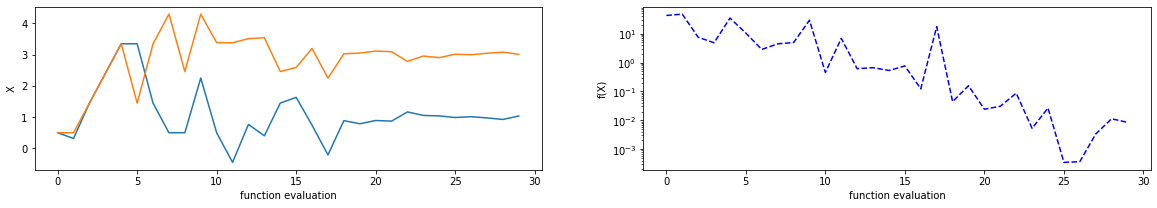

C:\Users\Adi\Dropbox (Technion Dropbox)\ML\Github projects\Bayesian-optimization-using-Gaussian-Process\modules\parallelstuff.py:442: RuntimeWarning: invalid value encountered in less_equal
  res = res[res[:,-1]<=res[nkeep-1,-1]] # list of nkeep coords and function evals there


In [10]:
Niter = 30
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', -mi.getState()[1])
    y_gp.append(-mi.getState()[1][0])
    plot_results(opt.X_obs,y_gp); plt.show()
    opt.OptIter()


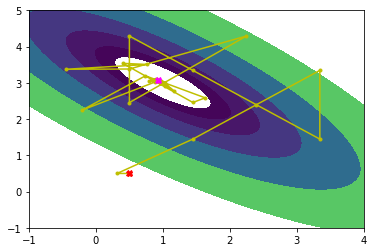

In [11]:
#plot acquisition in 2D
plt.contourf(X, Y, Z, levels = np.logspace(-0.1, 5, 6, base = 2));
plt.plot(opt.X_obs[:,0],opt.X_obs[:,1],'.-y'); plt.plot(opt.X_obs[0,0],opt.X_obs[0,1],marker='X',color='red')
plt.plot(opt.X_obs[-1,0],opt.X_obs[-1,1],marker='X',color='magenta');
plt.xlim([-1,4]); plt.ylim([-1,5]);    

# Gpy

In [12]:
import GPyOpt
from numpy.random import seed 

def booth(x):
    return (x[:,0]+2*x[:,1]-7)**2 + (x[:,1]+2*x[:,0]-5)**2

bounds =[{'name': 'x_1', 'type': 'continuous', 'domain': (-10,10)}, 
         {'name': 'x_2', 'type': 'continuous', 'domain': (-10,10)}]

seed(123) 

y_gpy = GPyOpt.methods.BayesianOptimization(booth,                   
                                                domain=bounds,                
                                                acquisition_type='EI',        
                                                exact_feval = True,           
                                                initial_design_type ="latin", 
                                                initial_design_numdata=20 )   
max_iter = 30
y_gpy.run_optimization(max_iter) 

min f: 0.01418
argmin f: 1.08298, 2.91470


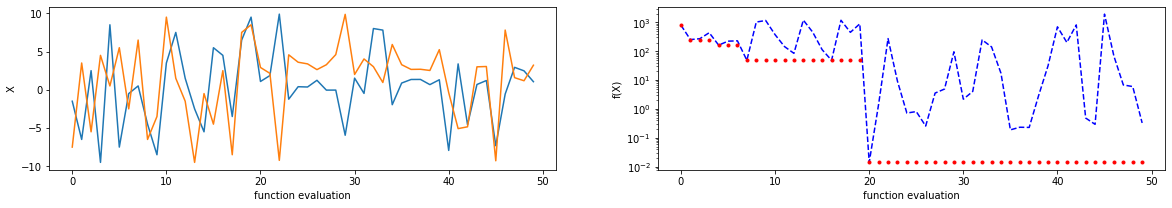

In [13]:
plot_results(y_gpy.get_evaluations()[0],y_gpy.get_evaluations()[1]);
plt.plot(y_gpy.Y_best,'.r');

print("min f: {:.5f}".format(y_gpy.fx_opt)) 
print("argmin f: {:.5f}, {:.5f}".format(y_gpy.x_opt[0], 
                                        y_gpy.x_opt[1]))

In [14]:
# y_gpy.plot_convergence() 
# y_gpy.plot_acquisition()
# print(y_gpy.model.get_model_parameters_names(),y_gpy.model.get_model_parameters())
# y_gpy.model_parameters_iterations

# Bayseopt 
Code from: https://github.com/fmfn/BayesianOptimization

In [59]:
from bayes_opt import BayesianOptimization

pbounds = {'x': (-10, 10),
           'y': (-10, 10)}

f = function()
def evaluate(x,y):
    return -1*f.Booth([x,y])

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
#     verbose=0
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -15.33    | -1.66     |  4.406    |
|  2        | -1.458e+0 | -9.998    | -3.953    |
|  3        | -1.667e+0 | -7.065    | -8.153    |
|  4        | -804.3    | -6.275    | -3.089    |
|  5        | -126.2    | -2.065    |  0.7763   |
|  6        | -28.91    | -1.798    |  3.517    |
|  7        | -15.85    | -1.639    |  4.296    |
|  8        | -17.28    | -1.785    |  4.413    |
|  9        | -11.01    | -1.406    |  4.581    |
|  10       | -7.8      | -1.074    |  4.768    |
|  11       | -7.188    | -0.9434   |  4.834    |
|  12       | -6.815    | -0.8175   |  4.871    |
|  13       | -6.047    | -0.6987   |  4.772    |
|  14       | -5.13     | -0.5784   |  4.622    |
|  15       | -3.717    | -0.3604   |  4.366    |
|  16       | -2.694    | -0.1356   |  4.182    |
|  17       | -2.154    |  0.07337  |  4.09     |
|  18       | -2.27     |  0.2211   |  4.108    |


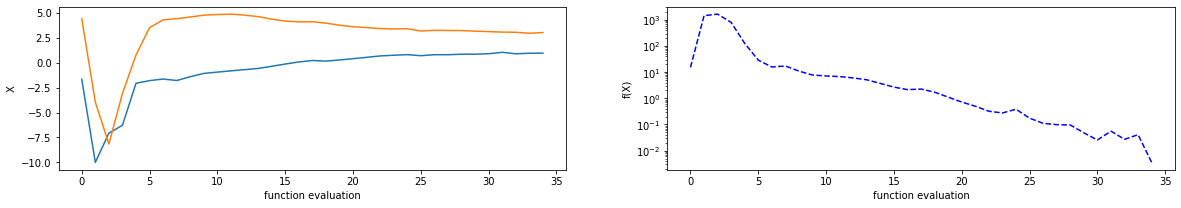

In [60]:
y_bo = f.my_y ; x_bo = f.my_x
plot_results(x_bo,y_bo)

# Simplex / L-BFGS-B 

In [61]:
from scipy.optimize import minimize

def more_optimizers(method=['Nelder-Mead','L-BFGS-B','CG'][0]):
    f = function()
    result = minimize(f.Booth, x0=xs, method=method)
    print("Found minimum at {0}".format(result.x))
    print("Number of function evaluations {0}".format(f.my_counter))
    return f.my_y , f.my_x

Found minimum at [0.99996897 3.00002341]
Number of function evaluations 80


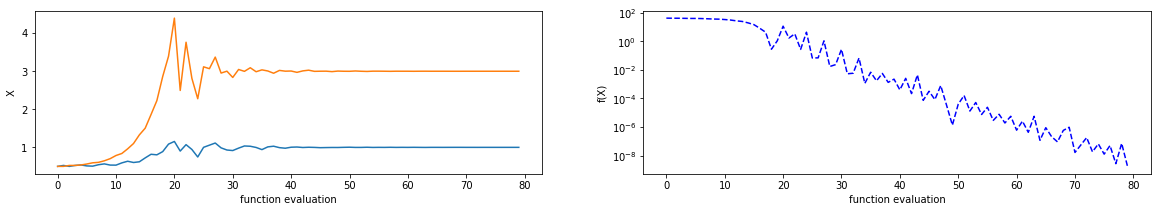

In [62]:
y_simplex , x_simplex = more_optimizers(method='Nelder-Mead')
plot_results(x_simplex,y_simplex)

In [68]:
# y_LBFGSB ,x_LBFGSB =more_optimizers(method='L-BFGS-B')
# plot_results(x_LBFGSB,y_LBFGSB)

# Compare all

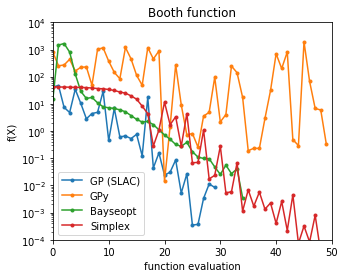

In [69]:
f = plt.figure(figsize=(5,4));  plt.xlabel('function evaluation'); plt.ylabel('f(X)')
plt.plot(y_gp,marker='.',linestyle='-',label='GP (SLAC)');
# plt.plot(y_gpy.Y_best,marker='.',linestyle='-',label='GPy, best');
plt.plot(y_gpy.get_evaluations()[1],marker='.',linestyle='-',label='GPy');
plt.plot(y_bo,marker='.',linestyle='-',label='Bayseopt');
plt.plot(y_simplex,marker='.',linestyle='-',label='Simplex');
# plt.plot(y_LBFGSB,marker='.',linestyle='-',label='L-BFGS-B');
plt.legend(fontsize = 10); 
plt.xlim([0,50]);
plt.yscale('log');
plt.ylim([10**-4,10**4]);
plt.title('Booth function');